In [1]:
import os
# os.environ["KERAS_BACKEND"] = "jax"

import gc
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

import tensorflow as tf
# import jax
import keras

from sklearn import metrics

from tqdm.notebook import tqdm
import random

print(tf.__version__)
# print(jax.__version__)

2.16.1


In [2]:
def is_interactive():
    return 'runtime' in get_ipython().config.IPKernelApp.connection_file

print('Interactive?', is_interactive())

Interactive? True


In [3]:
SEED = 42
keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()

In [4]:
# DATA = "/kaggle/input/leap-atmospheric-physics-ai-climsim"
DATA_NPY = "data"

In [5]:
sample = pl.read_csv('sample_submission.csv', n_rows=1)
TARGETS = sample.select(pl.exclude('sample_id')).columns
print(len(TARGETS))

368


In [6]:
BATCH_SIZE = 4096
DATA_TFREC = "data"
# create list of all tfrec files in folder and sub folders
TFREC_FILES = tf.io.gfile.glob(DATA_TFREC + '/**/*.tfrecord')
print(len(TFREC_FILES))
train_files = TFREC_FILES[1:46]
valid_files = TFREC_FILES[46:48]
train_options = tf.data.Options()
train_options.deterministic = True

def _parse_function(example_proto):
    feature_description = {
        'x': tf.io.FixedLenFeature([556], tf.float32),
        'targets': tf.io.FixedLenFeature([368], tf.float32)
    }
    e = tf.io.parse_single_example(example_proto, feature_description)
    return e['x'], e['targets'][120:180]

ds_train = (
  tf.data.TFRecordDataset(train_files, compression_type="GZIP")
    .with_options(train_options)
    .shuffle(100)
  .map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(4 * BATCH_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

ds_valid = (
    tf.data.TFRecordDataset(valid_files, compression_type="GZIP")
    .map(_parse_function)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
    )

47


In [7]:
norm_x = keras.layers.Normalization()
norm_x.adapt(ds_train.map(lambda x, y: x).take(1000))

2024-06-19 22:07:22.066329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
norm_y = keras.layers.Normalization()
norm_y.adapt(ds_train.map(lambda x, y: y).take(1000))

mean_y = norm_y.mean
stdd_y =keras.ops.maximum(1e-10, norm_y.variance ** 0.5)

2024-06-19 22:09:43.564804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
# mean_y = tf.cast(mean_y, tf.float64)
# stdd_y = tf.cast(stdd_y, tf.float64)

In [10]:
# min_y = np.min(np.stack([np.min(yb, 0) for _, yb in ds_train.take(1000)], 0), 0, keepdims=True)
# max_y = np.max(np.stack([np.max(yb, 0) for _, yb in ds_train.take(1000)], 0), 0, keepdims=True)

In [11]:
# min_y = tf.cast(min_y, tf.float64)
# max_y = tf.cast(max_y, tf.float64)

### Model definition & Training

In [12]:
@keras.saving.register_keras_serializable(package="MyMetrics", name="ClippedR2Score")
class ClippedR2Score(keras.metrics.Metric):
    def __init__(self, name='r2_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.base_metric = keras.metrics.R2Score(class_aggregation=None)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.base_metric.update_state(y_true, y_pred, sample_weight=None)
        
    def result(self):
        return keras.ops.mean(keras.ops.clip(self.base_metric.result(), 0.0, 1.0))
        
    def reset_states(self):
        self.base_metric.reset_states()

In [13]:
epochs = 12
learning_rate = 1e-3

epochs_warmup = 1
epochs_ending = 2
steps_per_epoch = int(np.ceil(len(train_files) * 100_000 / BATCH_SIZE))

lr_scheduler = tf.keras.optimizers.schedules.CosineDecay(
    1e-4,
    (epochs - epochs_warmup - epochs_ending) * steps_per_epoch, 
    warmup_target=learning_rate,
    warmup_steps=steps_per_epoch * epochs_warmup,
    alpha=0.1
)

In [14]:
import keras
import tensorflow as tf

keras.utils.clear_session()

def x_to_seq(x):
    x_seq0 = keras.ops.transpose(keras.ops.reshape(x[:, 0:60 * 6], (-1, 6, 60)), (0, 2, 1))
    x_seq1 = keras.ops.transpose(keras.ops.reshape(x[:, 60 * 6 + 16:60 * 9 + 16], (-1, 3, 60)), (0, 2, 1))
    x_flat = keras.ops.reshape(x[:, 60 * 6:60 * 6 + 16], (-1, 1, 16))
    x_flat = keras.ops.repeat(x_flat, 60, axis=1)
    # x_flat2 = keras.ops.reshape(x[:, 556:], (-1, 1, 19))
    # x_flat2 = keras.ops.repeat(x_flat2, 60, axis=1)
    return keras.ops.concatenate([x_seq0, x_seq1, x_flat], axis=-1)

def build_cnn(activation='relu'):    
    return keras.Sequential([
        # keras.layers.Conv1D(1024, 3, padding='same', activation=activation),
        keras.layers.Conv1D(512, 3, padding='same', activation=activation),
        # keras.layers.BatchNormalization(),
        keras.layers.Conv1D(256, 3, padding='same', activation=activation),
        # keras.layers.BatchNormalization(),
        keras.layers.Conv1D(128, 3, padding='same', activation=activation),
        # keras.layers.BatchNormalization(),
        keras.layers.Conv1D(164, 3, padding='same', activation=activation),
        # keras.layers.BatchNormalization(),
    ])

# Current track
X_input = x = keras.layers.Input(shape=(556,))
x = keras.layers.Normalization(mean=norm_x.mean, variance=norm_x.variance)(x)
x_seq = x_to_seq(x)

e = e0 = keras.layers.Conv1D(164, 1, padding='same')(x_seq)
e = build_cnn()(e)
# Add global average to allow some communication between all levels even in a small CNN
e = e0 + e + keras.layers.GlobalAveragePooling1D(keepdims=True)(e)
# e = keras.layers.BatchNormalization()(e)
e = e + build_cnn()(e)

p_all = keras.layers.Conv1D(1, 1, padding='same')(e)

# p_seq = p_all[:, :, :6]
p_seq = keras.ops.transpose(p_all, (0, 2, 1))
p_seq = keras.layers.Flatten()(p_seq)
assert p_seq.shape[-1] == 60

# Build & compile
model = keras.Model(inputs=X_input, outputs=p_seq)
model.compile(
    loss='mse', 
    optimizer=keras.optimizers.Adam(lr_scheduler),
    metrics=[ClippedR2Score()]
)

model.build(input_shape=(None, 556))
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 556)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 556)       │          0 │ input_layer[0][0] │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 360)       │          0 │ normalization[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 180)       │          0 │ normalization[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 16)        │          0 │ normalization[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 6, 60)     │          0 │ get_item[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 3, 60)     │          0 │ get_item_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 16)     │          0 │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose           │ (None, 60, 6)     │          0 │ reshape[0][0]     │
│ (Transpose)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose_1         │ (None, 60, 3)     │          0 │ reshape_1[0][0]   │
│ (Transpose)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat (Repeat)     │ (None, 60, 16)    │          0 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 60, 25)    │          0 │ transpose[0][0],  │
│ (Concatenate)       │                   │            │ transpose_1[0][0… │
│                     │                   │            │ repeat[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 60, 164)   │      4,264 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 60, 164)   │    807,460 │ conv1d[0][0]      │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 60, 164)   │          0 │ conv1d[0][0],     │
│                     │                   │            │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1, 164)    │          0 │ sequential[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 60, 164)   │          0 │ add[0][0],        │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 60, 164)   │    807,460 │ add_1[0][0]       │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,619,679 (6.18 MB)

 Trainable params: 1,619,679 (6.18 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# model_path = '/kaggle/input/leapseq2seq/model.keras'
# model = tf.keras.models.load_model(model_path)

In [16]:
ds_train_target_normalized = ds_train.map(lambda x, y: (x, (y - mean_y) / stdd_y))
ds_valid_target_normalized = ds_valid.map(lambda x, y: (x, (y - mean_y) / stdd_y))

history = model.fit(
    ds_train_target_normalized,
    validation_data=ds_valid_target_normalized,
    epochs=epochs,
    verbose=1 if is_interactive() else 2,
    callbacks=[
        keras.callbacks.ModelCheckpoint(filepath='models/cnn2b.keras'),
        # keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2, verbose=1, monitor='val_r2_score', mode='max', min_lr=1e-6)
    ]
)

Epoch 1/12
   9234/Unknown 13080s 1s/step - loss: 0.4207 - r2_score: 0.2389

2024-06-20 01:47:45.358830: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_28/_68]]
2024-06-20 01:47:45.358849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/johnny/anaconda3/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-06-20 01:49:24.681926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-20 01:49:24.681960: W tensorflow/core/framework/local_rendez

9234/9234 ━━━━━━━━━━━━━━━━━━━━ 13180s 1s/step - loss: 0.4207 - r2_score: 0.2389 - val_loss: 0.3175 - val_r2_score: 0.3482
Epoch 2/12
9234/9234 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.3318 - r2_score: 0.3364

2024-06-20 05:23:35.246175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-20 05:23:35.246202: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_26/_66]]
2024-06-20 05:25:13.865140: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-20 05:25:13.865168: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape_1/_8]]


9234/9234 ━━━━━━━━━━━━━━━━━━━━ 12949s 1s/step - loss: 0.3318 - r2_score: 0.3364 - val_loss: 0.3013 - val_r2_score: 0.3664
Epoch 3/12
9234/9234 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.3222 - r2_score: 0.3482

2024-06-20 08:59:11.408938: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-20 08:59:11.408962: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_14/_52]]
2024-06-20 09:00:54.996886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-20 09:00:54.996904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape_1/_8]]


9234/9234 ━━━━━━━━━━━━━━━━━━━━ 12941s 1s/step - loss: 0.3222 - r2_score: 0.3482 - val_loss: 0.2945 - val_r2_score: 0.3744
Epoch 4/12
9234/9234 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.3171 - r2_score: 0.3552

2024-06-20 12:49:58.310813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-20 12:49:58.310909: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_40/_46]]
2024-06-20 12:51:46.347005: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-20 12:51:46.347021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape_1/_8]]


9234/9234 ━━━━━━━━━━━━━━━━━━━━ 13851s 1s/step - loss: 0.3171 - r2_score: 0.3552 - val_loss: 0.2913 - val_r2_score: 0.3782
Epoch 5/12
9234/9234 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.3136 - r2_score: 0.3587

2024-06-20 16:41:38.847486: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-20 16:41:38.847506: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_20/_60]]
2024-06-20 16:43:23.551631: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-20 16:43:23.551667: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Size/_6]]


9234/9234 ━━━━━━━━━━━━━━━━━━━━ 13897s 2s/step - loss: 0.3136 - r2_score: 0.3587 - val_loss: 0.2878 - val_r2_score: 0.3834
Epoch 6/12
9234/9234 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.3105 - r2_score: 0.3631

2024-06-20 20:35:53.373511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-20 20:35:53.373569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_6/_82]]
2024-06-20 20:37:40.239322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-20 20:37:40.239344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_12]]


9234/9234 ━━━━━━━━━━━━━━━━━━━━ 14057s 2s/step - loss: 0.3105 - r2_score: 0.3631 - val_loss: 0.2864 - val_r2_score: 0.3841
Epoch 7/12
9234/9234 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.3079 - r2_score: 0.3669

2024-06-21 00:10:25.430878: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-21 00:10:25.430900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_6/_82]]
2024-06-21 00:11:58.106208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-21 00:11:58.106249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape_1/_8]]


9234/9234 ━━━━━━━━━━━━━━━━━━━━ 12858s 1s/step - loss: 0.3079 - r2_score: 0.3669 - val_loss: 0.2836 - val_r2_score: 0.3883
Epoch 8/12
9234/9234 ━━━━━━━━━━━━━━━━━━━━ 0s 983ms/step - loss: 0.3063 - r2_score: 0.3685

2024-06-21 02:43:16.612207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-21 02:43:16.612240: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_44]]


9234/9234 ━━━━━━━━━━━━━━━━━━━━ 9144s 990ms/step - loss: 0.3063 - r2_score: 0.3685 - val_loss: 0.2821 - val_r2_score: 0.3890
Epoch 9/12


2024-06-21 02:44:22.094428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-21 02:44:22.094446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape_1/_8]]


9234/9234 ━━━━━━━━━━━━━━━━━━━━ 0s 851ms/step - loss: 0.3040 - r2_score: 0.3714

2024-06-21 04:55:23.877947: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-21 04:55:23.877966: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_44]]


9234/9234 ━━━━━━━━━━━━━━━━━━━━ 7927s 858ms/step - loss: 0.3040 - r2_score: 0.3714 - val_loss: 0.2817 - val_r2_score: 0.3900
Epoch 10/12


2024-06-21 04:56:29.097622: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-21 04:56:29.097645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IsInf/_18]]


9234/9234 ━━━━━━━━━━━━━━━━━━━━ 0s 852ms/step - loss: 0.3027 - r2_score: 0.3730

2024-06-21 07:07:35.506914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-21 07:07:35.506961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_40/_46]]


9234/9234 ━━━━━━━━━━━━━━━━━━━━ 7932s 859ms/step - loss: 0.3027 - r2_score: 0.3730 - val_loss: 0.2808 - val_r2_score: 0.3904
Epoch 11/12


2024-06-21 07:08:41.254916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-21 07:08:41.254940: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape_1/_8]]


9234/9234 ━━━━━━━━━━━━━━━━━━━━ 0s 851ms/step - loss: 0.3016 - r2_score: 0.3741

2024-06-21 09:19:44.421337: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-21 09:19:44.421360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_44]]


9234/9234 ━━━━━━━━━━━━━━━━━━━━ 7928s 859ms/step - loss: 0.3016 - r2_score: 0.3741 - val_loss: 0.2790 - val_r2_score: 0.3945
Epoch 12/12


2024-06-21 09:20:49.572641: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-21 09:20:49.572657: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_12]]


9234/9234 ━━━━━━━━━━━━━━━━━━━━ 0s 909ms/step - loss: 0.2998 - r2_score: 0.3765

2024-06-21 11:40:46.676745: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-21 11:40:46.676784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_44]]


9234/9234 ━━━━━━━━━━━━━━━━━━━━ 8430s 913ms/step - loss: 0.2998 - r2_score: 0.3765 - val_loss: 0.2798 - val_r2_score: 0.3913


2024-06-21 11:41:19.941531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-21 11:41:19.941547: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape_1/_8]]


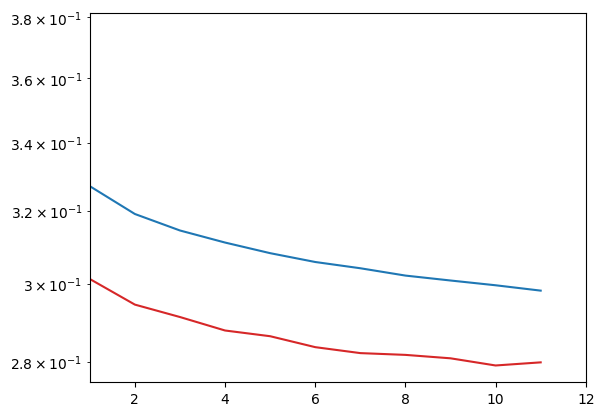

In [17]:
plt.plot(history.history['loss'], color='tab:blue')
plt.plot(history.history['val_loss'], color='tab:red')
plt.xlim(1, epochs)
plt.yscale('log');

In [18]:
y_valid = np.concatenate([yb for _, yb in ds_valid])
p_valid = model.predict(ds_valid, batch_size=BATCH_SIZE) * stdd_y + mean_y

2024-06-21 11:41:41.192671: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


210/210 ━━━━━━━━━━━━━━━━━━━━ 32s 151ms/step


2024-06-21 11:42:13.200750: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/Users/johnny/anaconda3/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [19]:
p_valid.numpy()[0]

array([-1.9841172e-13, -1.9941960e-12, -4.4517520e-13,  1.2103268e-12,
        5.1723887e-13,  3.2272283e-13, -7.4515996e-13, -2.1390859e-13,
        6.2244575e-14, -1.1092052e-15, -1.2602266e-13, -5.6015755e-13,
        2.9839968e-14, -1.7360688e-13, -5.9616008e-14,  7.6881324e-13,
        2.7005920e-13, -1.3744717e-12, -5.1585130e-13, -7.9532735e-12,
       -2.8294511e-11, -1.0514800e-10, -1.9840549e-10, -1.8214906e-10,
        8.1763429e-11,  1.2078133e-10,  4.0386150e-10,  6.8972272e-10,
        6.5618444e-10,  1.2788772e-09,  3.1053113e-09,  6.0554877e-09,
        8.1774072e-09,  8.5998506e-09,  6.2529724e-09,  5.4232077e-09,
        7.2345339e-09,  9.3364507e-09,  9.3247809e-09,  8.0465430e-09,
        7.4388016e-09,  6.6300432e-09,  5.9522050e-09,  6.2764269e-09,
        8.7816705e-09,  7.6793825e-09,  9.7965147e-09,  5.9094667e-09,
        8.9213223e-09,  1.2996467e-08, -1.4268231e-08, -3.6547825e-09,
       -2.5444091e-11,  4.1222146e-09,  3.5439935e-09,  2.2075266e-09,
      

In [20]:
scores_valid = np.array([metrics.r2_score(y_valid[:, i], p_valid[:, i]) for i in range(len(TARGETS))])
plt.plot(scores_valid.clip(-1, 1))

ValueError: Input arrays use different devices: cpu, /job:localhost/replica:0/task:0/device:GPU:0

In [ ]:
mask = scores_valid <= 1e-3
f"Number of under-performing targets: {sum(mask)}"

In [ ]:
f"Clipped score: {scores_valid.clip(0, 1).mean()}"

In [ ]:
del y_valid, p_valid
gc.collect();